<a href="https://colab.research.google.com/github/SambhavDeev/Seq2Seq-Trnsltr-Hin2Eng/blob/main/Seq2Seq_Hindi2English_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modules

In [ ]:
#https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works
#With __future__ module's inclusion, you can slowly be accustomed to incompatible changes or to such ones introducing new keywords.
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Dataset

In [ ]:

path_to_zip = tf.keras.utils.get_file(
    'hin-eng.zip', origin='https://drive.google.com/u/0/uc?id=1YSxk17Dj6qwJAKbBqFbvPE3gBjQPe68X&export=download',
    extract=True)


89831/89831 [==============================] - 0s 0us/step


In [ ]:


path_to_file = os.path.join(os.path.dirname(path_to_zip), "hin.txt")




# **TEXT PREPROCESSING**

In [ ]:
def preprocess_sentence(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
en_sentence = u"where did you go?"
hi_sentence = u"तुम कहाँ गए थे?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(hi_sentence).encode('utf-8'))

<start> where did you go ? <end>
b'<start> \xe0\xa4\xa4\xe0\xa5\x81\xe0\xa4\xae \xe0\xa4\x95\xe0\xa4\xb9\xe0\xa4\xbe\xe0\xa4\x81 \xe0\xa4\x97\xe0\xa4\x8f \xe0\xa4\xa5\xe0\xa5\x87 ? <end>'


# CREATING DATASET


In [ ]:
lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')

In [ ]:
num_examples = len(lines)
word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

In [ ]:
en = [pair[0] for pair in word_pairs]
hi = [pair[1] for pair in word_pairs]


In [ ]:
print(en[10])
print(hi[10])

<start> I'm OK . <end>
<start> मैं ठीक हूँ। <end>


# maximum length function of tensor

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Tokenizeing function

In [ ]:
def tokenize(lang):
  #below code vectorizes text and returns a sequence of integer
  #you can read more about this here
  #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  #here fit and text to sequence works same as we have seen in scikit learn
  lang_tokenizer.fit_on_texts(lang)

  #transforms into sequence of information
  #https://rdrr.io/cran/keras/man/texts_to_sequences.html
  tensor = lang_tokenizer.texts_to_sequences(lang)

  #this will do post padding of tensor
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # Open the file, read it, strip from beginning and end, and split the lines when "\n" is found
    lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
    num_examples = len(lines)
    # Preprocess word pairs
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    # Unzip the word pairs
    #we can change the targ_lang ,inp_lang like inp_lang , targ_lang to create english to hindi translation
    #here we are doing hindi to english translation
    targ_lang, inp_lang = zip(*word_pairs)

    # Tokenize input and target languages
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset("hin.txt", num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Dividing dataset into train and validation

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2246 2246 562 562


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
11 ----> क्या
23 ----> तुम
55 ----> उस
128 ----> आदमी
14 ----> को
54 ----> उसकी
424 ----> तस्वीर
9 ----> से
965 ----> पहचान
65 ----> सकते
17 ----> हो
4 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
44 ----> can
7 ----> you
2010 ----> identify
4 ----> the
97 ----> man
13 ----> in
17 ----> this
449 ----> picture
8 ----> ?
2 ----> <end>


**Create a tf.data dataset**

In [ ]:
#length of input tensor train
BUFFER_SIZE = len(input_tensor_train)
#batch size
BATCH_SIZE = 64
#steps taken in each epochs
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#total embedding dimensions of tensor
embedding_dim = 256
units = 1024
#vocabulary size of input and target
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

#tf.data.Dataset.from_tensor.slices
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 29]), TensorShape([64, 27]))

# ENCODER

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):

    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 29, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


**ATTEENTION LAYER**

In [ ]:

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 29, 1)


# DECODER

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2402)


**Define the optimizer and the loss function**

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Checkpoints (Object-based saving)**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# TRAINING

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5630
Epoch 1 Loss 1.8422
Time taken for 1 epoch 47.37025499343872 sec

Epoch 2 Batch 0 Loss 1.6280
Epoch 2 Loss 1.5443
Time taken for 1 epoch 7.696852445602417 sec

Epoch 3 Batch 0 Loss 1.5559
Epoch 3 Loss 1.4327
Time taken for 1 epoch 7.098610877990723 sec

Epoch 4 Batch 0 Loss 1.3457
Epoch 4 Loss 1.3424
Time taken for 1 epoch 7.687498331069946 sec

Epoch 5 Batch 0 Loss 1.2332
Epoch 5 Loss 1.2580
Time taken for 1 epoch 6.7169718742370605 sec

Epoch 6 Batch 0 Loss 1.1511
Epoch 6 Loss 1.1783
Time taken for 1 epoch 7.126287937164307 sec

Epoch 7 Batch 0 Loss 1.1334
Epoch 7 Loss 1.1099
Time taken for 1 epoch 6.857282876968384 sec

Epoch 8 Batch 0 Loss 1.1787
Epoch 8 Loss 1.0519
Time taken for 1 epoch 7.27100944519043 sec

Epoch 9 Batch 0 Loss 0.9454
Epoch 9 Loss 0.9929
Time taken for 1 epoch 6.673911809921265 sec

Epoch 10 Batch 0 Loss 0.8995
Epoch 10 Loss 0.9370
Time taken for 1 epoch 7.307145833969116 sec

Epoch 11 Batch 0 Loss 0.9037
Epoch 11 Loss 0.8798
Time tak

# Translate

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
%matplotlib inline
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


**Restore the latest checkpoint and test**

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> तुम कहाँ गए थे ? <end>
Predicted translation: where were you ? <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


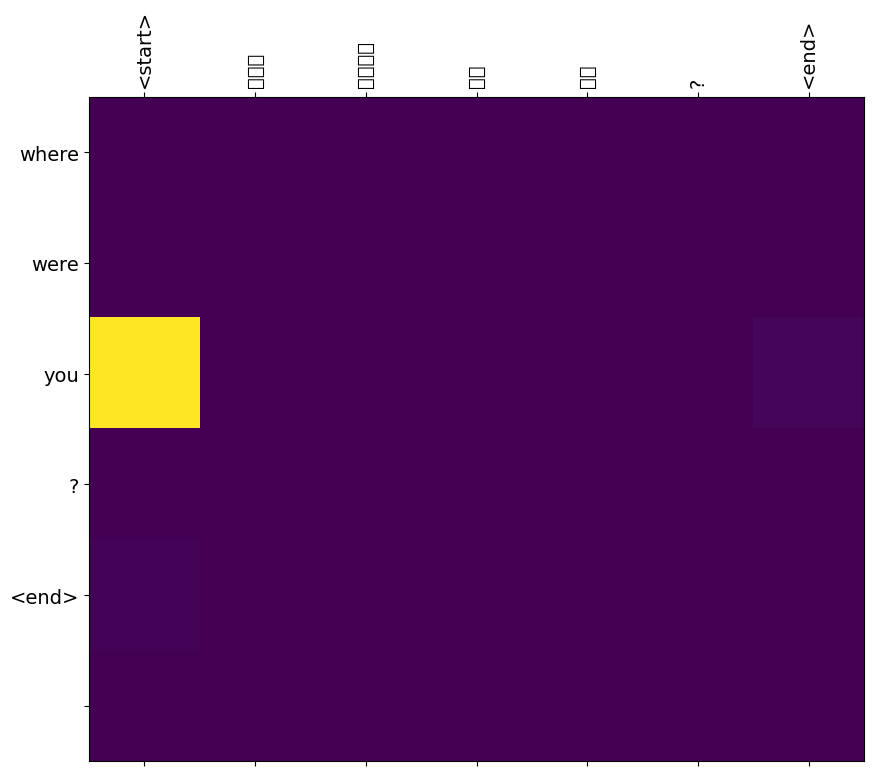

In [ ]:
translate(u'तुम कहाँ गए थे?')

Input: <start> और एक बार। <end>
Predicted translation: once again . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2324 (\N{DEVANAGARI LETTER AU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


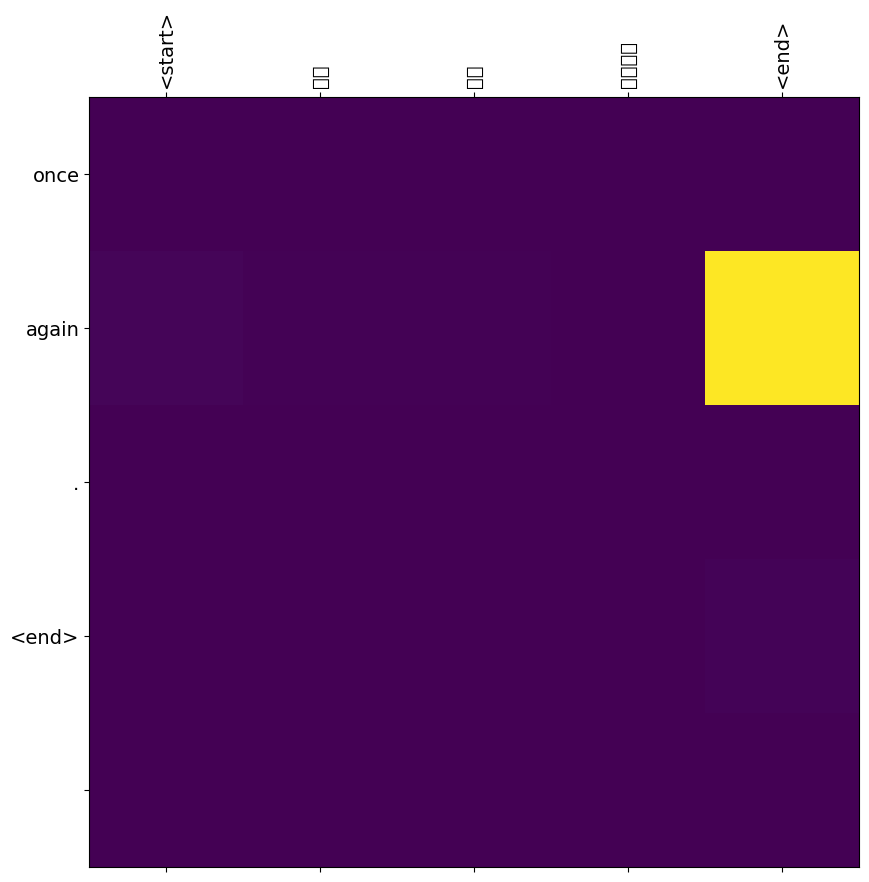

In [ ]:
translate(u" और एक बार।")

Input: <start> दुनिया चाय के बिना क्या करेगी ? <end>
Predicted translation: what's the temperature ? <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2330 (\N{DEVANAGARI LETTER CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools

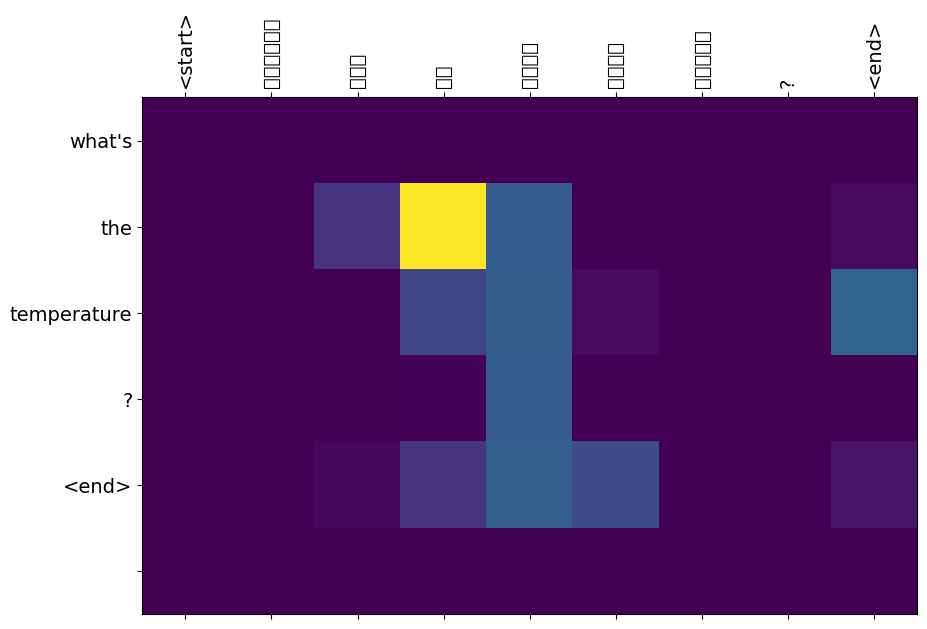

In [ ]:
translate(u" दुनिया चाय के बिना क्या करेगी?")

Input: <start> मुझे उससे प्यार हो गया। <end>
Predicted translation: i fell in love with her . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


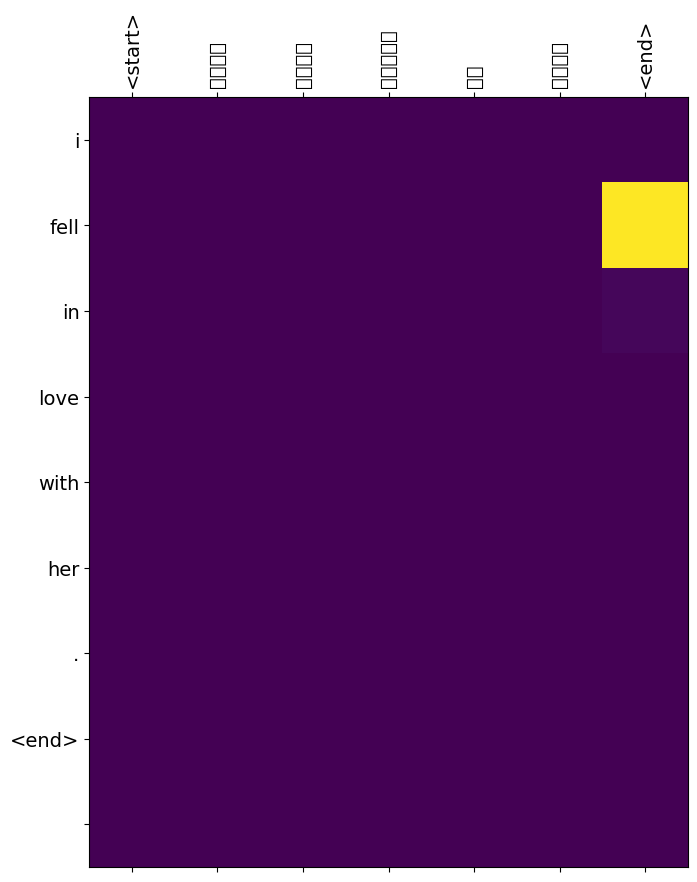

In [ ]:
translate(u"मुझे उससे प्यार हो गया।")

Input: <start> मेरे पास ज़्यादा पैसे नहीं हैं। <end>
Predicted translation: i have a lot . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:1

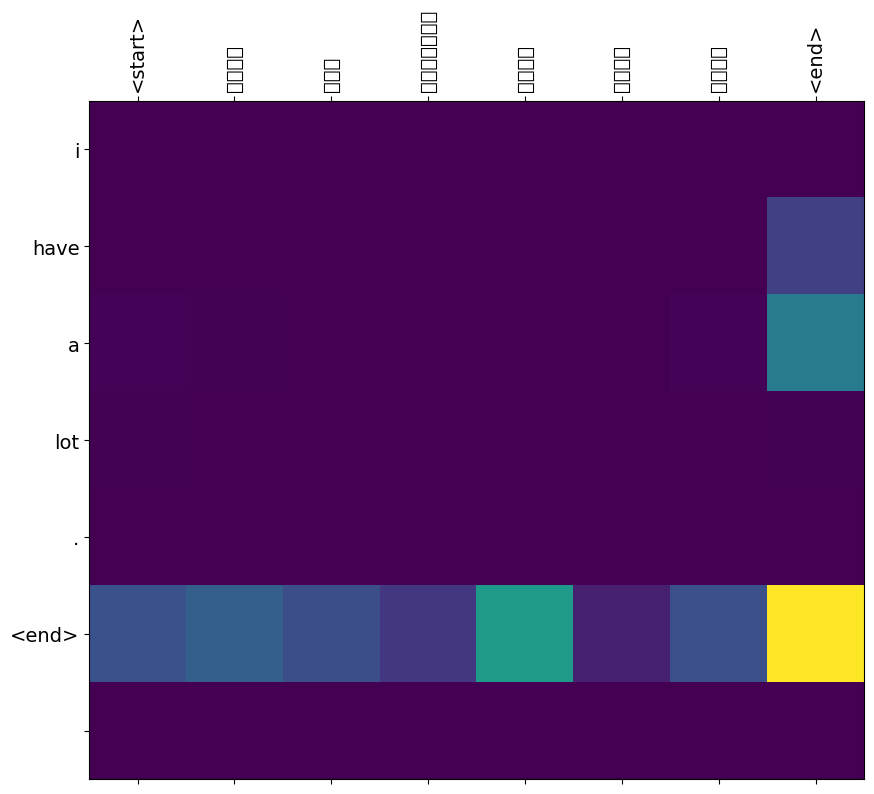

In [ ]:
translate(u"मेरे पास ज़्यादा पैसे नहीं हैं।")

Input: <start> तुम्हारी याददाश्त अच्छी है। <end>
Predicted translation: you have a good memory . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:1

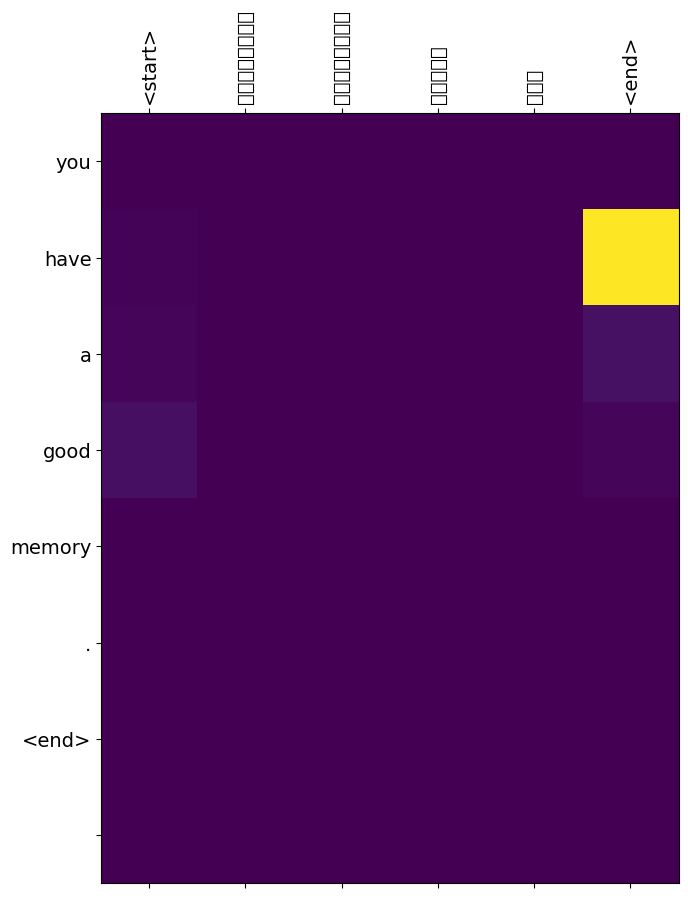

In [ ]:
translate(u"तुम्हारी याददाश्त अच्छी है।")

Input: <start> तुम अंग्रेज़ी नहीं बोल सकते हो क्या ? <end>
Predicted translation: can't you speak english ? <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:1

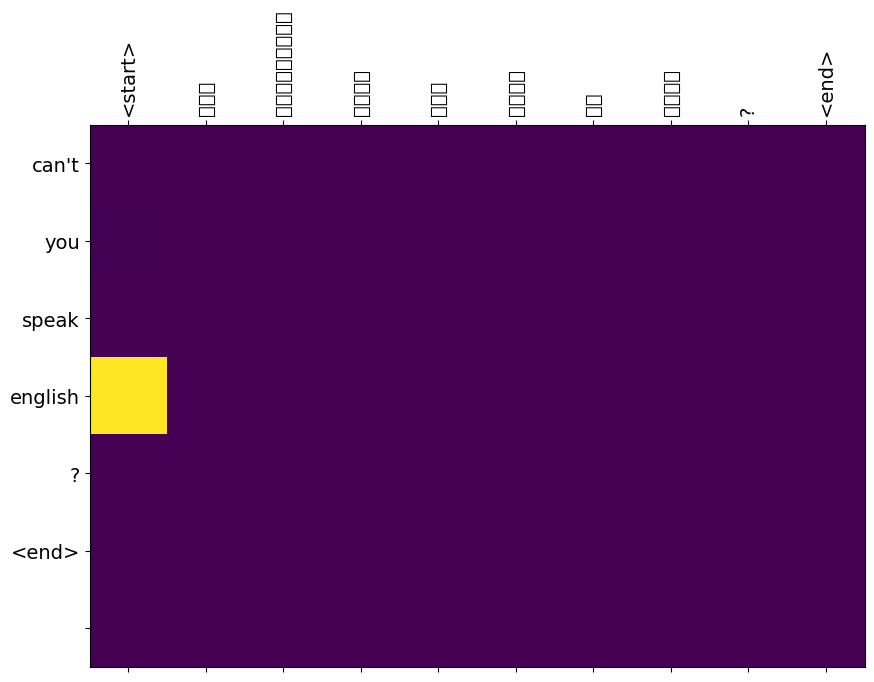

In [ ]:
translate(u"तुम अंग्रेज़ी नहीं बोल सकते हो क्या?")

Input: <start> मुझे एक ब्लडी मेरी चाहिए। <end>
Predicted translation: i'd like a bloody mary . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:1

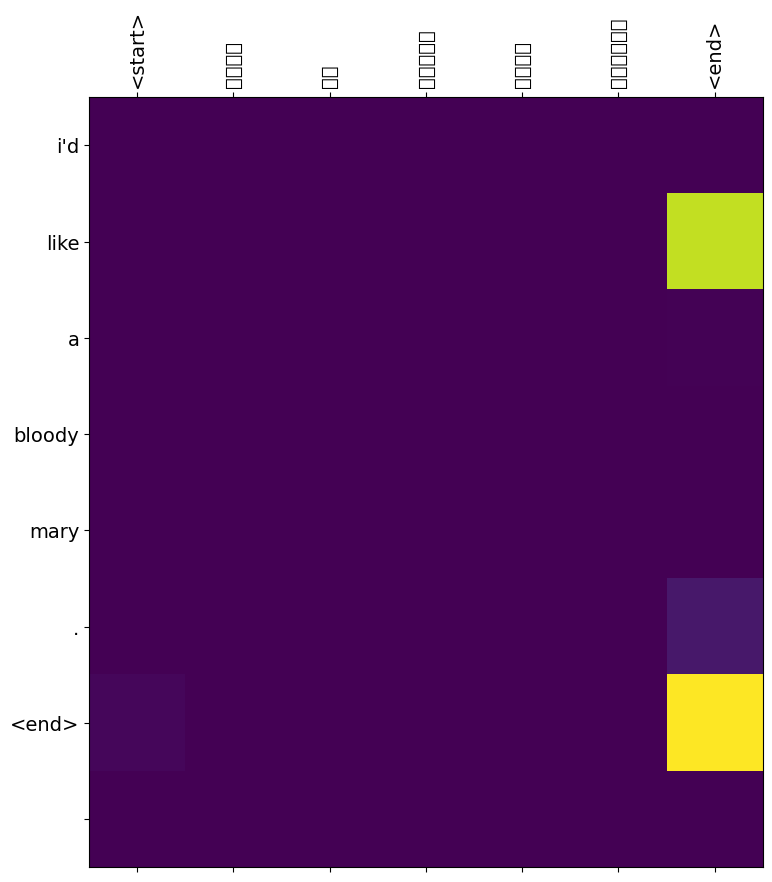

In [ ]:
translate(u"मुझे एक ब्लडी मेरी चाहिए।")

Input: <start> मैंने यह बनाया है <end>
Predicted translation: i like playing the spa . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pyla

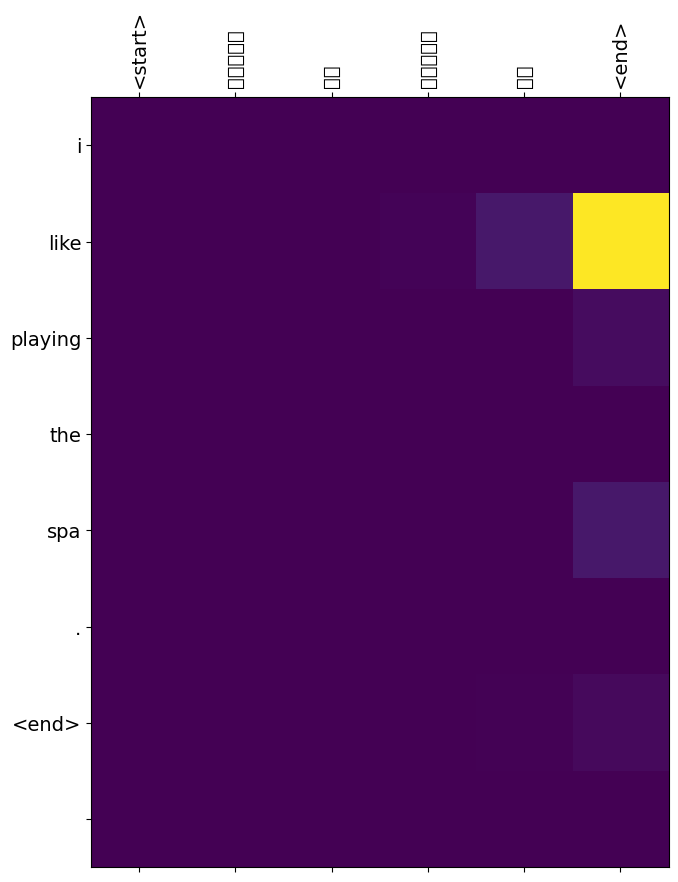

In [ ]:
translate(u"मैंने यह बनाया है")

Input: <start> ये अजीब है , नहीं ? <end>
Predicted translation: that's weird , isn't it ? <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


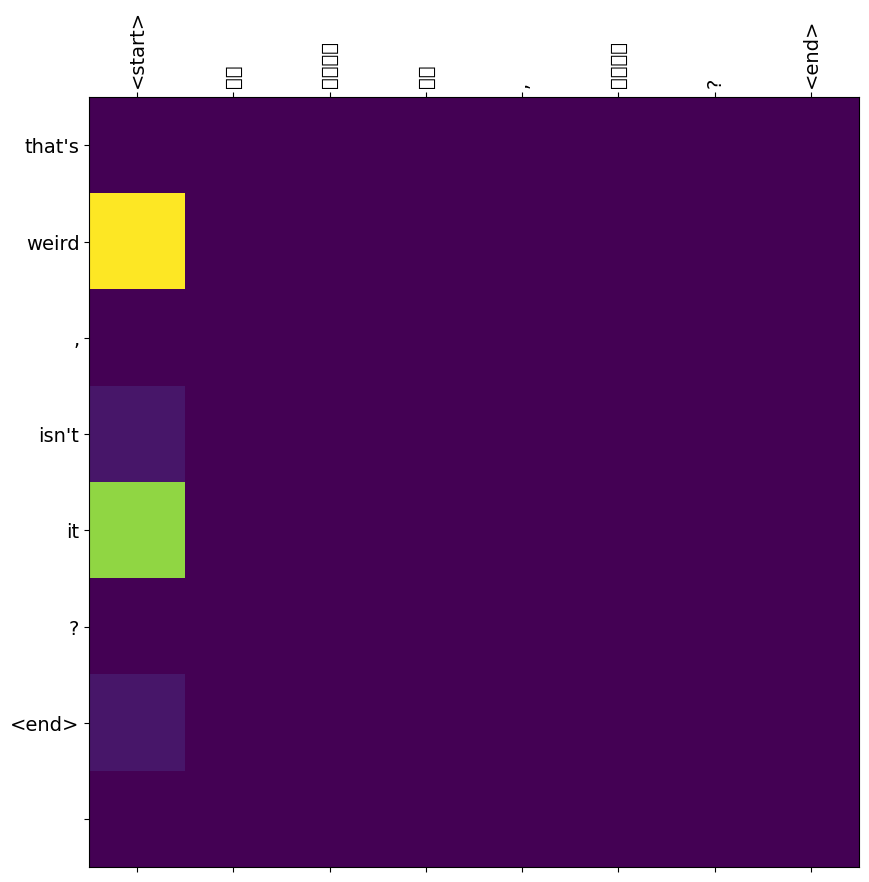

In [ ]:
translate(u"ये अजीब है, नहीं?")

Input: <start> मुझे नौकरी से निकाला नहीं गया। मैंने खुद ही नौकरी छोड़ दी। <end>
Predicted translation: i wasn't fired . i quit . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2380 (\N{DEVANAGARI VOWEL SIGN AU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtoo

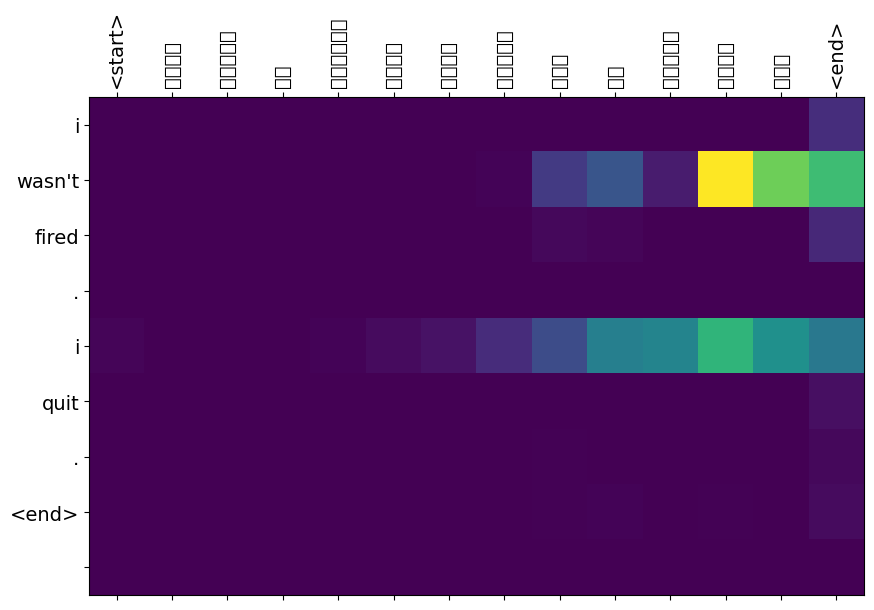

In [ ]:
translate(u"मुझे नौकरी से निकाला नहीं गया। मैंने खुद ही नौकरी छोड़ दी।")

Input: <start> मैं अच्छा नहीं कर रहा हूँ <end>
Predicted translation: i will be pleased . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


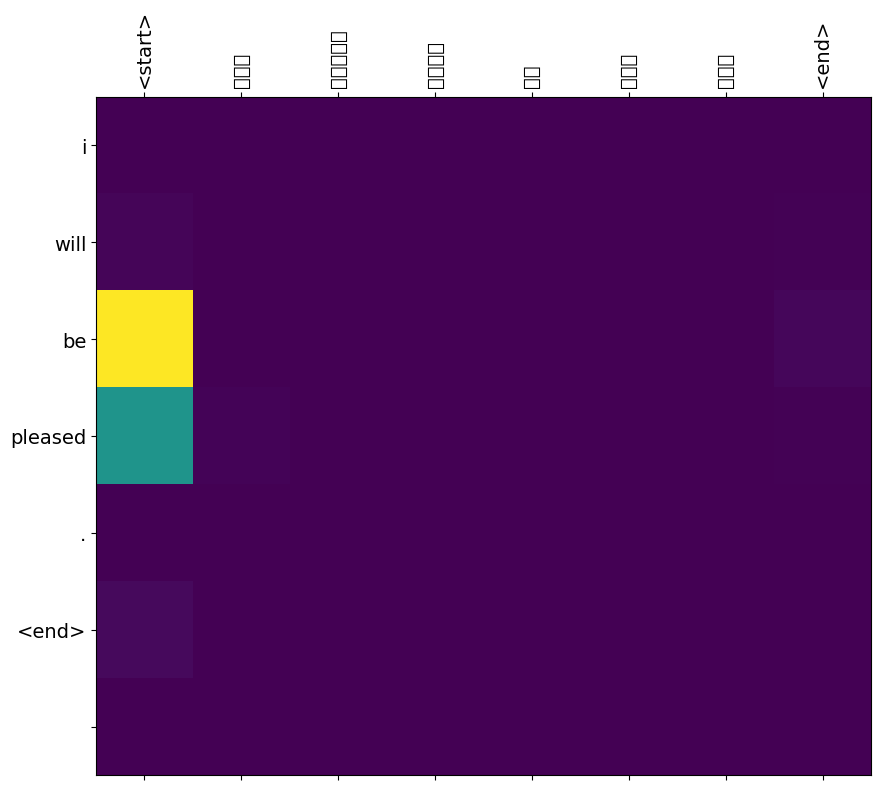

In [ ]:
translate(u"मैं अच्छा नहीं कर रहा हूँ")

Input: <start> मेरा दिल लग रहा है <end>
Predicted translation: he has been crying . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


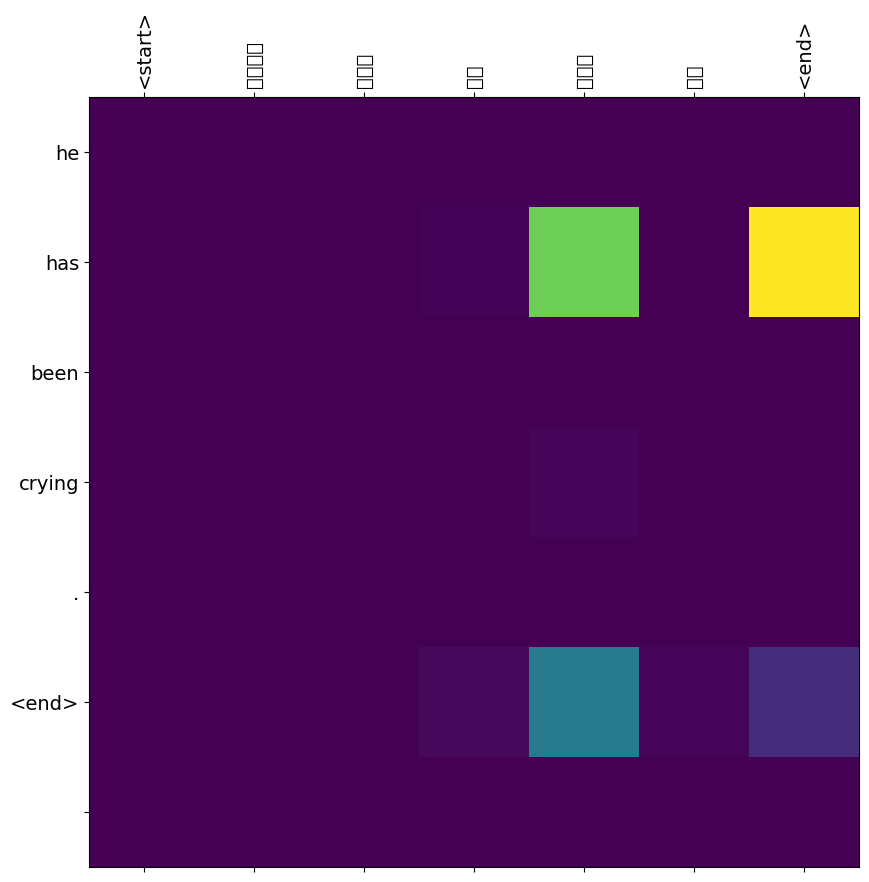

In [ ]:
translate(u"मेरा दिल लग रहा है")

Input: <start> उनका मज़ाक मत उड़ाओ। <end>
Predicted translation: don't do not to ask for me . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2323 (\N{DEVANAGARI LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


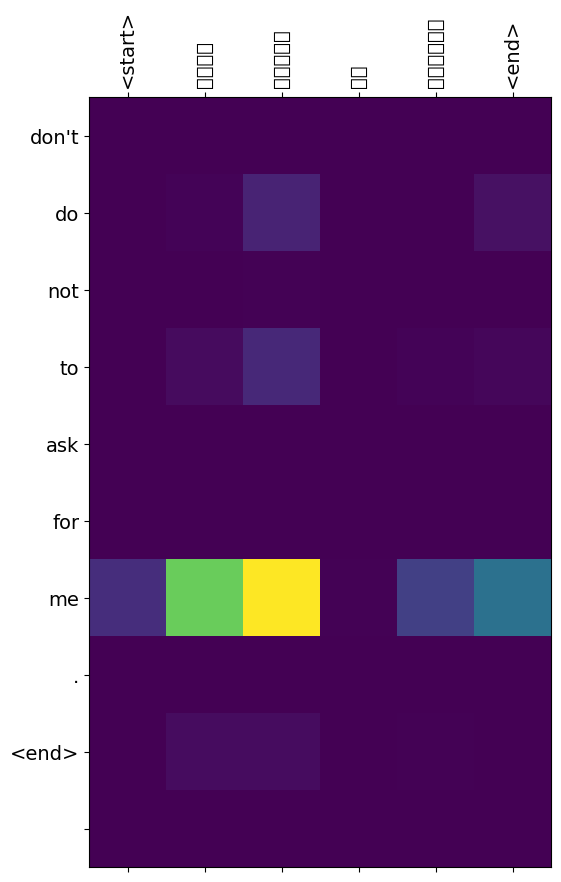

In [ ]:
translate(u"उनका मज़ाक मत उड़ाओ।")

Input: <start> मुझसे पैसे मत माँगो। <end>
Predicted translation: don't ask me for money . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


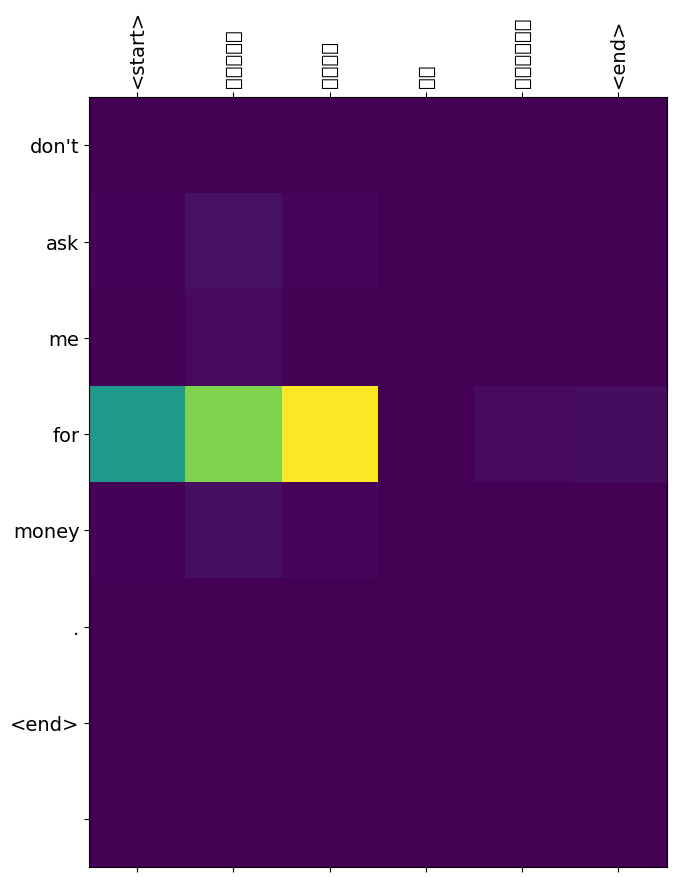

In [ ]:
translate(u"मुझसे पैसे मत माँगो।")

Input: <start> क्या आपके पास किताब है ? <end>
Predicted translation: is mary your daughter ? <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


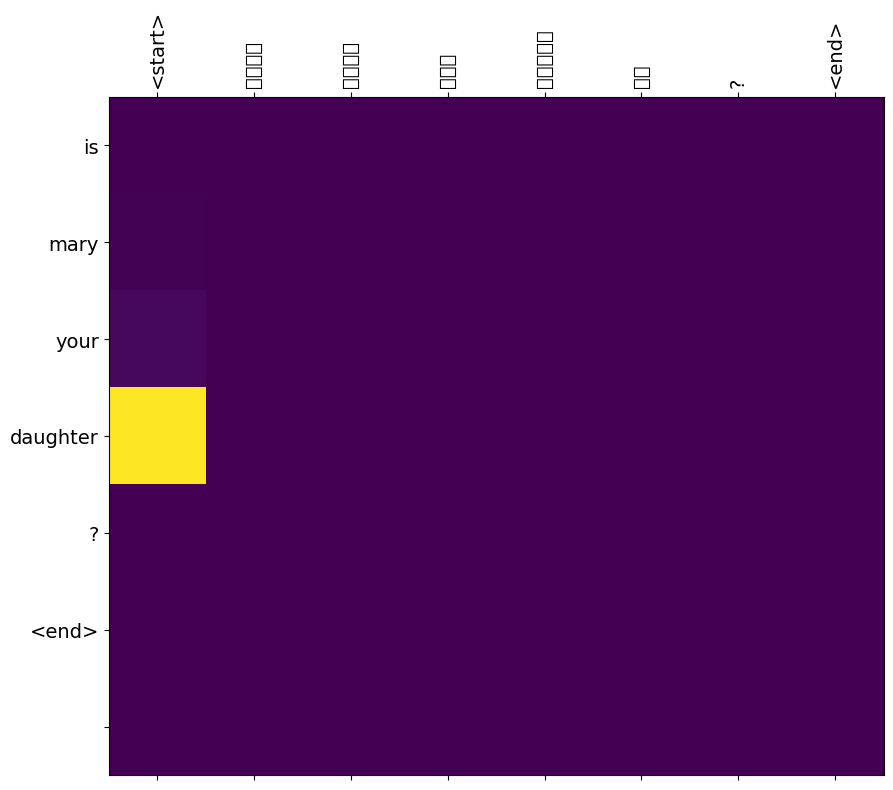

In [ ]:
translate(u"क्या आपके पास किताब है?")

Input: <start> इस कीमत में टैक्स शामिल है। <end>
Predicted translation: this amount includes tax . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2311 (\N{DEVANAGARI LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2358 (\N{DEVANAGARI LETTER SHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


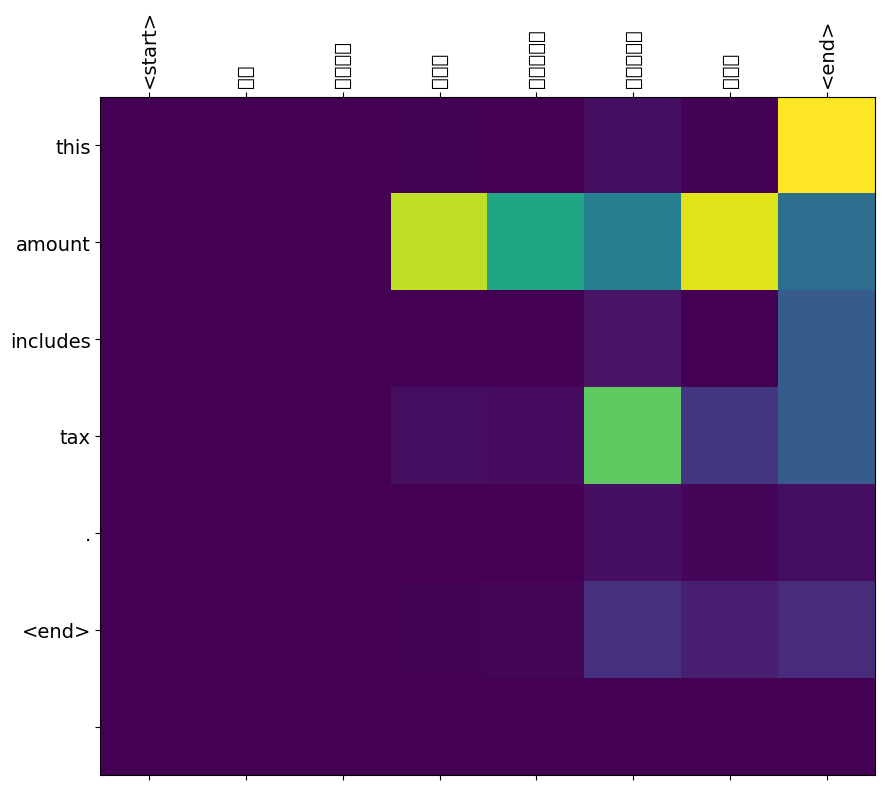

In [ ]:
translate(u"इस कीमत में टैक्स शामिल है।")

Input: <start> समाप्त <end>
Predicted translation: the work . <end> 


<ipython-input-38-0800e104a68b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-0800e104a68b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


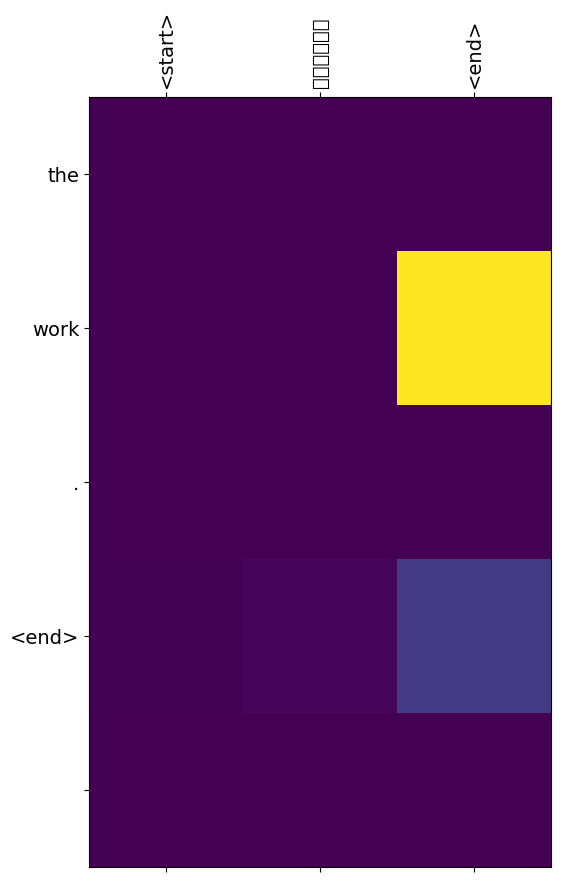

In [ ]:
translate(u"समाप्त")